***Paso 1.*** Abre el archivo de datos y estudia la información general 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

# Cargar el dataset
df = pd.read_csv('/datasets/games.csv')

# Ver información general sobre el dataframe
df.info()

#Ver las primeras filas.
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08  

**Paso 2.** Prepara los datos

Reemplaza los nombres de las columnas (ponlos en minúsculas).
Convierte los datos en los tipos necesarios.

In [2]:
#1. Renombrar las columnas (minúsculas)
df.columns = df.columns.str.lower()

#2. Convertir tipos de datos 
# Convertir 'year_of_release' a tipo entero (algunos valores están en float por los NaN)
df['year_of_release'] = df['year_of_release'].dropna().astype(int)

# Convertir 'user_score' a tipo numérico (hay valores tipo texto como 'tbd' que impiden convertir)
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

# Convertir columnas de texto libre a string
df['name'] = df['name'].astype('string')

# Convertir columnas con valores repetidos a categoría
df['platform'] = df['platform'].astype('category')
df['genre'] = df['genre'].astype('category')
df['rating'] = df['rating'].astype('category')

# Asegurarse de que 'user_score' sea float (por si no lo hiciste antes)
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16713 non-null  string  
 1   platform         16715 non-null  category
 2   year_of_release  16446 non-null  float64 
 3   genre            16713 non-null  category
 4   na_sales         16715 non-null  float64 
 5   eu_sales         16715 non-null  float64 
 6   jp_sales         16715 non-null  float64 
 7   other_sales      16715 non-null  float64 
 8   critic_score     8137 non-null   float64 
 9   user_score       7590 non-null   float64 
 10  rating           9949 non-null   category
dtypes: category(3), float64(7), string(1)
memory usage: 1.1 MB


1. name → de object a string.
   Esta columna contiene texto libre (el nombre de cada videojuego). Usar el tipo string moderno de pandas mejora la compatibilidad con operaciones de texto y es más eficiente que object.
    
2. platform → de object a category.
   Representa el nombre de la consola (Wii, PS4, etc.). Tiene un número limitado de valores únicos, por lo que usar category ahorra memoria y mejora el rendimiento en agrupaciones y comparaciones.

3. genre → de object a category.
   Contiene géneros como 'Action', 'RPG', 'Shooter', etc. También son datos repetidos y discretos. category es más adecuado para análisis estadístico y visualizaciones.

4. rating → de object a category.
   Esta columna almacena las clasificaciones ESRB (como 'E', 'M', 'T'). Son pocos valores posibles y representan categorías definidas, no texto libre.

5. user_score → de object a float64.
   Originalmente contenía cadenas de texto, incluidas entradas no numéricas como "tbd". Se transformó a float para permitir análisis cuantitativos. Los valores no convertibles fueron reemplazados con NaN.

6. year_of_release → de float64 a int64.
   Aunque era float64 debido a la presencia de NaN, representa un año, que es un número entero. Se convirtió a int64 para análisis más precisos (por ejemplo, comparar años, agrupar por año, etc.). Antes se eliminaron los NaN o se trataron.

**Manejo de valores ausentes**

In [3]:
# Reemplazar TBD con NaN en user_score
df['user_score'] = df['user_score'].replace('tbd', np.nan)

# Convertir user_score a float
df['user_score'] = df['user_score'].astype(float)

# Eliminar filas sin year_of_release
df = df[df['year_of_release'].notna()]

# Convertir year_of_release a int
df['year_of_release'] = df['year_of_release'].astype(int)

# Agregar 'Unknown' a las categorías permitidas
df['rating'] = df['rating'].cat.add_categories(['TBD'])

# Ahora puedes rellenar sin error
df['rating'] = df['rating'].fillna('TBD')

Estrategia adoptada por columna:
1. year_of_release (año de lanzamiento)
    
    Acción: Eliminar filas con NaN si se requiere análisis por año.

    Justificación: No se puede imputar un año de lanzamiento sin sesgar los resultados.


2. critic_score y user_score
    
    Acción: Mantener los valores nulos (NaN).

    Justificación: No todos los juegos son evaluados, y rellenar con media o mediana podría falsear los análisis.


3. user_score tenía valores 'tbd'
    
    Acción específica: Convertidos a NaN con pd.to_numeric(..., errors='coerce').

    Justificación: "tbd" significa que aún no hay puntuación, así que es lógico tratarlo como ausente.


4. rating
    
    Acción: Mantener los NaN o, si se desea, usar una categoría "Sin clasificar".

    Justificación: Algunos juegos no reciben clasificación ESRB (por ejemplo, lanzamientos internacionales).

**Calcula las ventas totales (la suma de las ventas en todas las regiones) para cada juego y coloca estos valores en una columna separada.**

In [4]:
# Crear columna de ventas totales
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

**Paso 3. Analiza los datos**

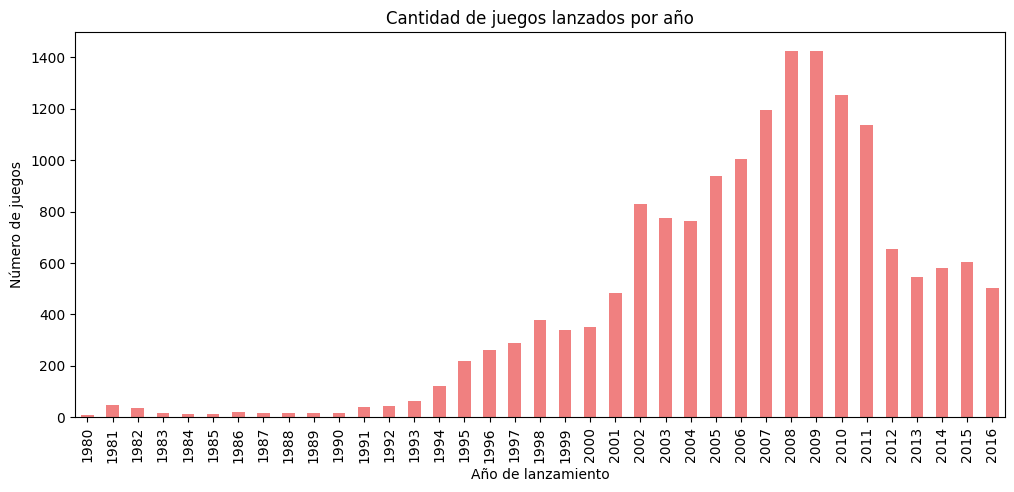

In [5]:
#1. ¿Cuántos juegos fueron lanzados por año?
games_per_year = df['year_of_release'].value_counts().sort_index()
games_per_year.plot(
    kind='bar',
    title='Cantidad de juegos lanzados por año',
    xlabel='Año de lanzamiento',
    ylabel='Número de juegos',
    figsize=(12,5),
    color='lightcoral'
)
plt.show()

**¿Son significativos los datos de cada período?**

Si, podemos ver que la cantidad de juegos lanzados empieza a obtener traccion oficialmente despues de 1995, llegando al pico en 2008

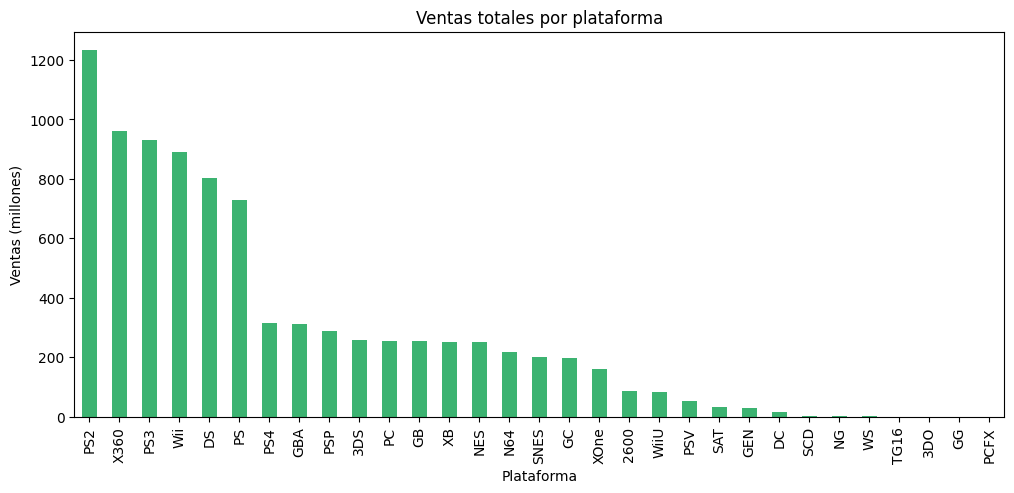

In [6]:
#2. ¿Qué plataformas tienen más ventas totales?
platform_sales = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
platform_sales.plot(
    kind='bar',
    title='Ventas totales por plataforma',
    xlabel='Plataforma',
    ylabel='Ventas (millones)',
    color='mediumseagreen',
    figsize=(12,5)
)
plt.show()

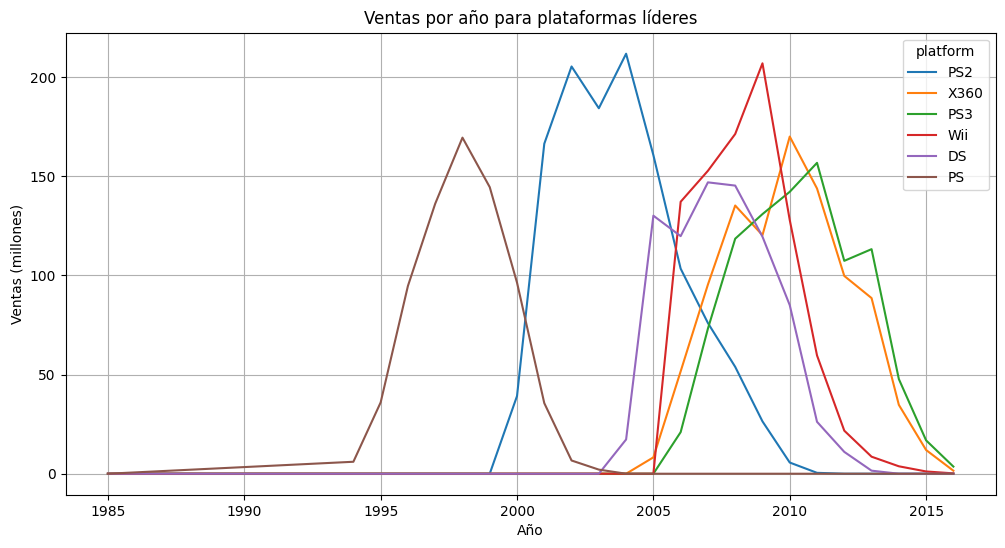

In [7]:
#3. Evolución anual de ventas por plataforma
top_platforms = platform_sales.head(6).index
df_top = df[df['platform'].isin(top_platforms)]

# Filtrar DataFrame solo con esas plataformas
df_top = df[df['platform'].isin(top_platforms)]

# Crear pivot solo con plataformas relevantes
pivot = df_top.pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc='sum'
)

# Asegurar que las columnas estén solo en top_platforms y en orden
pivot = pivot[top_platforms]

# Graficar
pivot.plot(
    kind='line',
    title='Ventas por año para plataformas líderes',
    xlabel='Año',
    ylabel='Ventas (millones)',
    figsize=(12,6)
)
plt.grid(True)
plt.show()

**Busca las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?**

Las plataformas suelen tener un ciclo de vida de una decada, las plataformas mas populares son testamento de la longitud mas saludable del ciclo de vida de las plataformas.

In [8]:
# 4. Determina el período de datos para el modelo (para predecir 2017)
df_recent = df[df['year_of_release'] >= 2012]

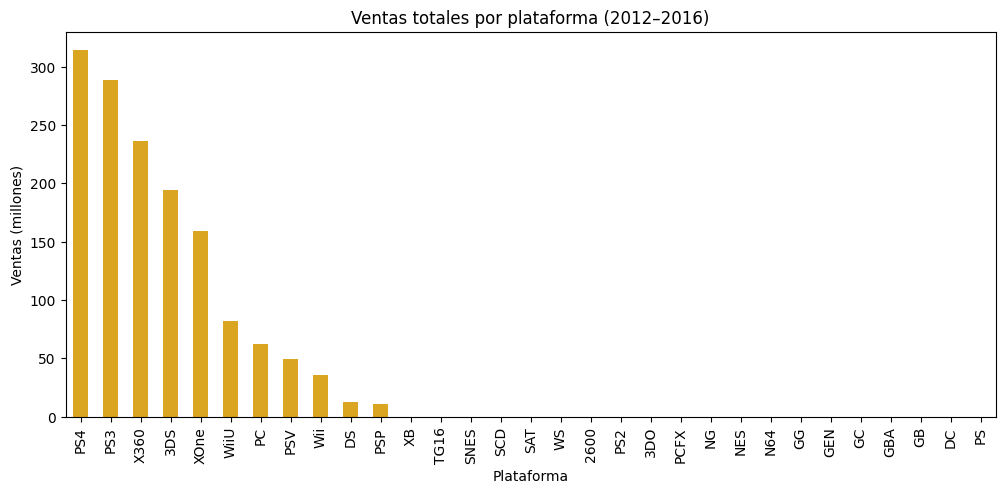

In [9]:
#5. ¿Qué plataformas son más rentables desde 2012?
recent_platform_sales = df_recent.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
recent_platform_sales.plot(
    kind='bar',
    title='Ventas totales por plataforma (2012–2016)',
    xlabel='Plataforma',
    ylabel='Ventas (millones)',
    color='goldenrod',
    figsize=(12,5)
)
plt.show()

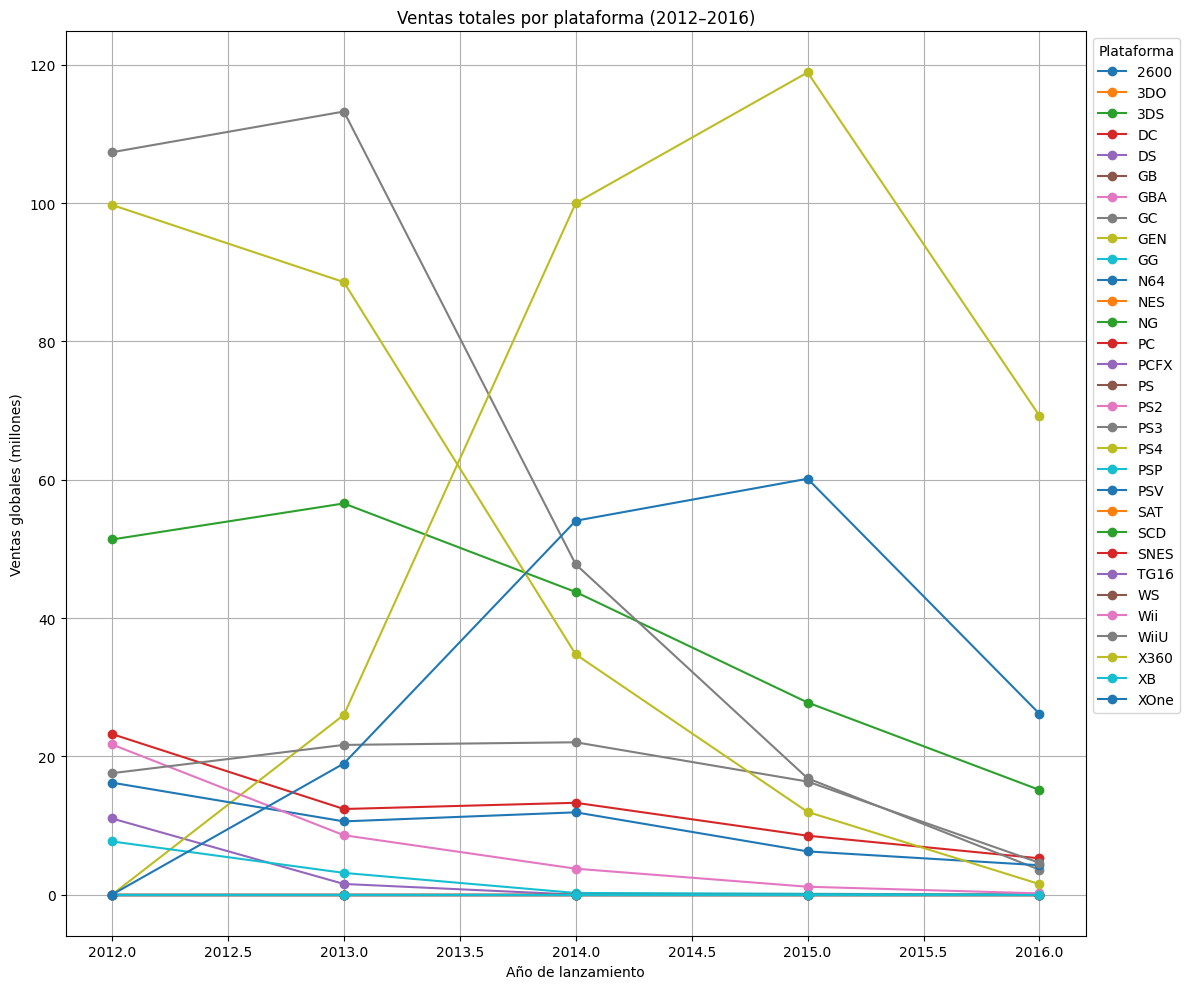

In [10]:
#modelo para 2017.
# Filtrar datos entre 2012 y 2016
df_modelo = df[(df['year_of_release'] >= 2012) & (df['year_of_release'] <= 2016)]

# Elegir las plataformas más activas en ese periodo
platform_sales_model = df_modelo.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
top_platforms_model = platform_sales_model.index

# Filtrar nuevamente por las plataformas líderes
df_modelo_top = df_modelo[df_modelo['platform'].isin(top_platforms_model)]

# Crear tabla dinámica con años en filas, plataformas en columnas, sumando ventas
pivot_model = df_modelo_top.pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc='sum'
)

# Gráfico de líneas
pivot_model.plot(
    kind='line',
    figsize=(12,10),
    marker='o',
    title='Ventas totales por plataforma (2012–2016)'
)
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas globales (millones)')
plt.grid(True)
plt.legend(title='Plataforma', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()


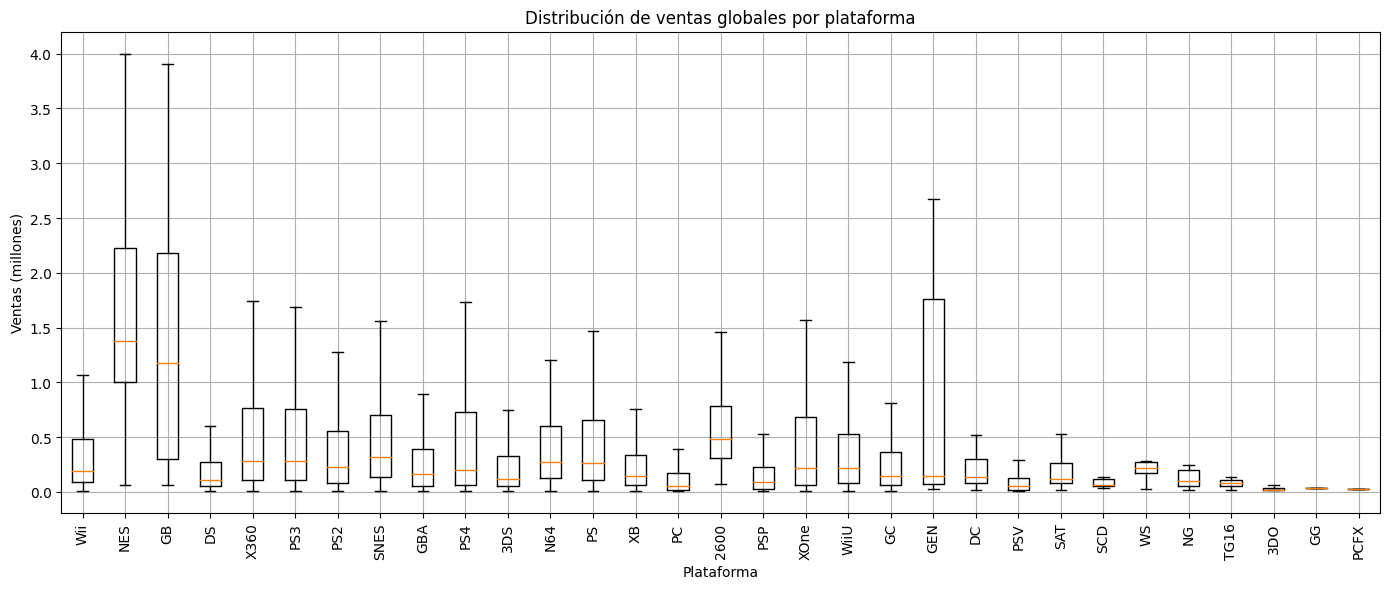

In [11]:
#6. Diagrama de caja por plataforma
# Filtramos los juegos con ventas > 0 para evitar distorsión por ceros
df_filtrado = df[df['total_sales'] > 0]

# Agrupamos las ventas por plataforma
ventas_por_plataforma = [df_filtrado[df_filtrado['platform'] == pl]['total_sales'] for pl in df_filtrado['platform'].unique()]
plataformas = df_filtrado['platform'].unique()

# Graficamos
plt.figure(figsize=(14, 6))
plt.boxplot(ventas_por_plataforma, labels=plataformas, showfliers=False)  # showfliers=False para ocultar outliers
plt.xticks(rotation=90)
plt.title('Distribución de ventas globales por plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Ventas (millones)')
plt.grid(True)
plt.tight_layout()
plt.show()

**¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.**

Las consolas de NES y GB tienen grandes cantidades de promedio, pero usualmente las ventas promedias son en cantidades pequeñas mientras que las cantidades grandes son extremas, pero las plataformas viejas apenas tienen presencia en las distribuciones de ventas globales.

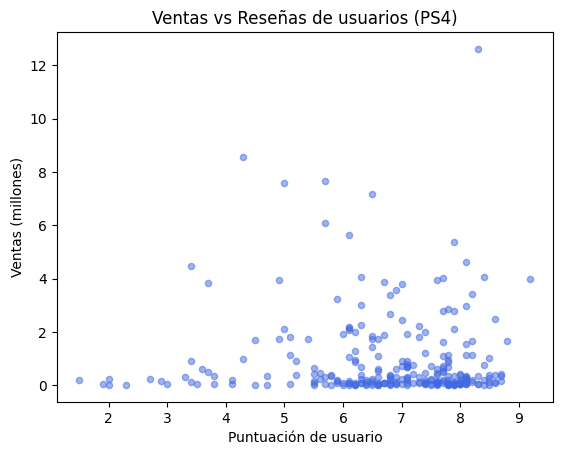

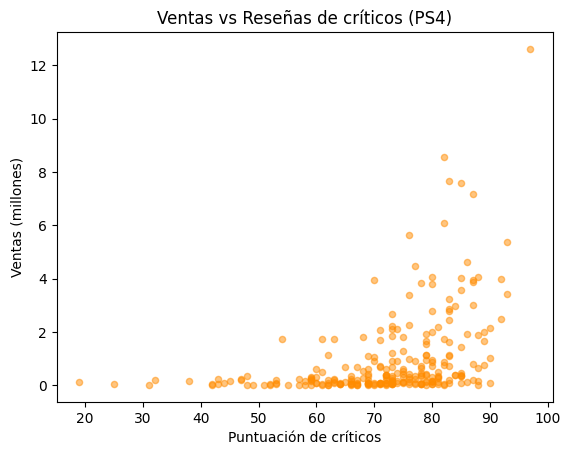

Correlación user_score: -0.031957110204556424
Correlación critic_score: 0.40656790206178095


In [12]:
#7. ¿Influyen las reseñas en las ventas? (Ej: PS4)
ps4 = df[df['platform'] == 'PS4']

# Gráfico de dispersión
ps4.plot(
    kind='scatter',
    x='user_score',
    y='total_sales',
    title='Ventas vs Reseñas de usuarios (PS4)',
    xlabel='Puntuación de usuario',
    ylabel='Ventas (millones)',
    color='royalblue',
    alpha=0.5
)
plt.show()

ps4.plot(
    kind='scatter',
    x='critic_score',
    y='total_sales',
    title='Ventas vs Reseñas de críticos (PS4)',
    xlabel='Puntuación de críticos',
    ylabel='Ventas (millones)',
    color='darkorange',
    alpha=0.5
)
plt.show()

# Correlación
print("Correlación user_score:", ps4['user_score'].corr(ps4['total_sales']))
print("Correlación critic_score:", ps4['critic_score'].corr(ps4['total_sales']))

**Conclusiones:**

La correlación suele ser débil o moderada con críticos, y muy baja con usuarios. pero en general, no hay mucha diferencia de ventas entre los Scores que obtienen.

In [13]:
#8. Compara los mismos juegos en distintas plataformas
# Juegos con el mismo nombre en varias plataformas
multi_platform = df[df.duplicated('name', keep=False)]
multi_platform = multi_platform.sort_values('name')

print(multi_platform[['name', 'platform', 'total_sales']].head(20))

                                                    name platform  total_sales
3862                                Frozen: Olaf's Quest       DS         0.51
3358                                Frozen: Olaf's Quest      3DS         0.59
1285                              007: Quantum of Solace     X360         1.48
4475                              007: Quantum of Solace      PS2         0.43
1785                              007: Quantum of Solace      PS3         1.15
14658                             007: Quantum of Solace       PC         0.02
3120                              007: Quantum of Solace      Wii         0.65
9507                              007: Quantum of Solace       DS         0.13
2243                        007: The World is not Enough       PS         0.92
1204                        007: The World is not Enough      N64         1.56
15656                                  11eyes: CrossOver      PSP         0.02
15091                                  11eyes: Cross

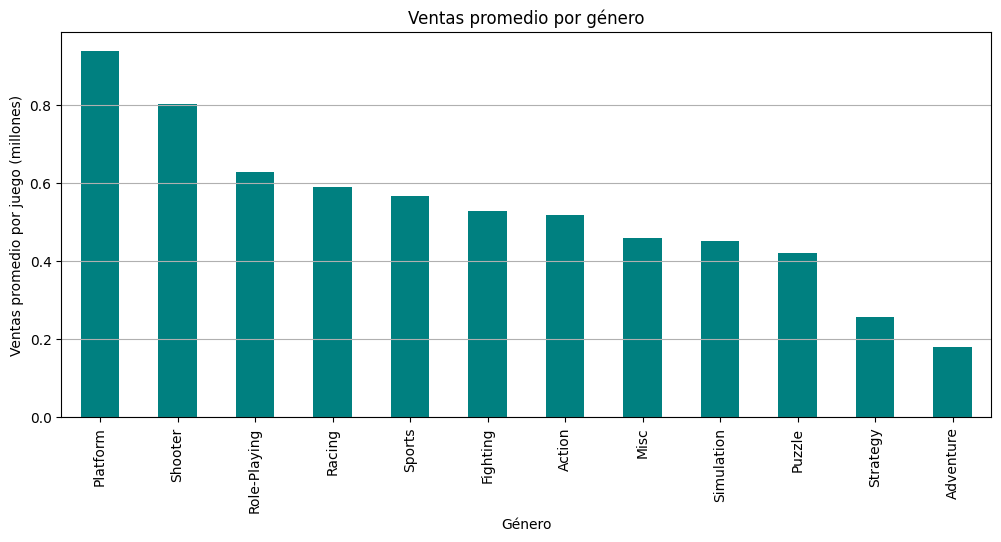

In [14]:
#9. Distribución de juegos por género
# Calcular ventas promedio por género
genre_avg_sales = df.groupby('genre')['total_sales'].mean().sort_values(ascending=False)

# Crear gráfico
genre_avg_sales.plot(
    kind='bar',
    title='Ventas promedio por género',
    xlabel='Género',
    ylabel='Ventas promedio por juego (millones)',
    color='teal',
    figsize=(12,5)
)
plt.grid(axis='y')
plt.show()

**¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?**

Los generos mas rentables son los de Accion, Shooters, Roleplaying, Racing, Sports  y  peleas, esto es con la informacion de ventas promedio de ventas.

**Paso 4. Crea un perfil de usuario para cada región**

**Top 5 plataformas por región**

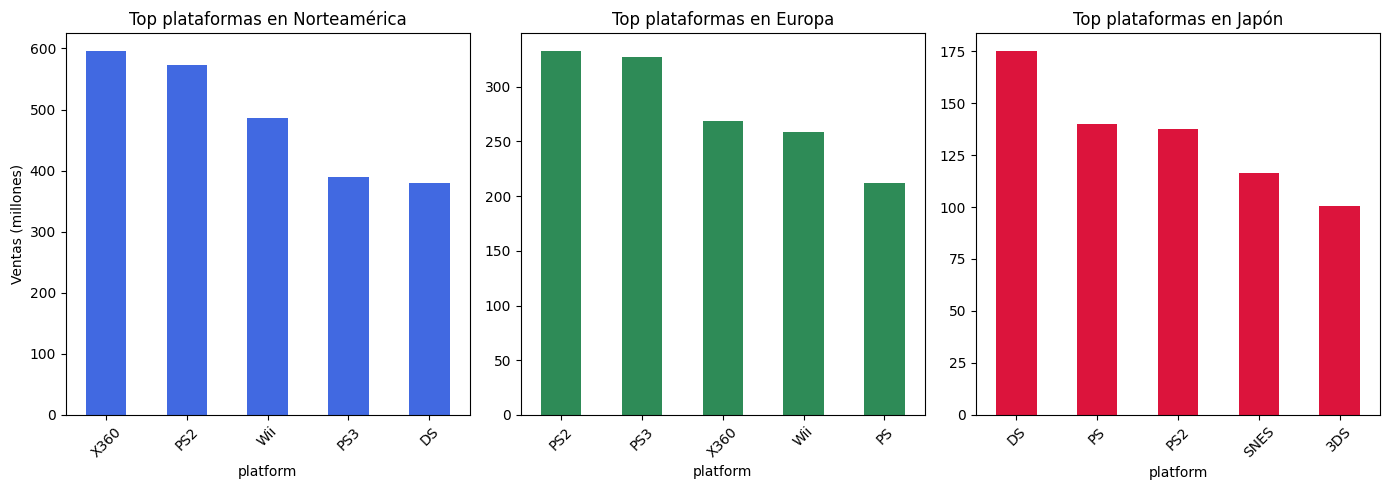

In [15]:
# Top 5 plataformas por región
na_platforms = df.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_platforms = df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_platforms = df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Gráfico comparativo
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
na_platforms.plot(kind='bar', title='Top plataformas en Norteamérica', ylabel='Ventas (millones)', color='royalblue')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
eu_platforms.plot(kind='bar', title='Top plataformas en Europa', color='seagreen')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
jp_platforms.plot(kind='bar', title='Top plataformas en Japón', color='crimson')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Top 5 géneros por región**

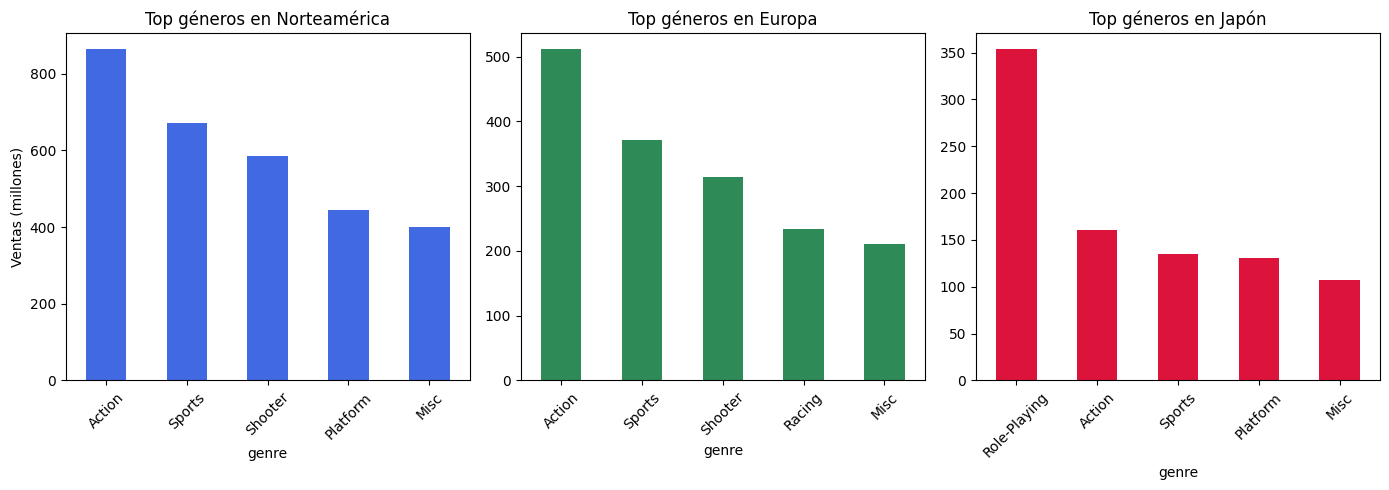

In [16]:
# Top 5 géneros por región
na_genres = df.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_genres = df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_genres = df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Gráfico comparativo
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
na_genres.plot(kind='bar', title='Top géneros en Norteamérica', ylabel='Ventas (millones)', color='royalblue')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
eu_genres.plot(kind='bar', title='Top géneros en Europa', color='seagreen')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
jp_genres.plot(kind='bar', title='Top géneros en Japón', color='crimson')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Efecto del rating ESRB en ventas por región**

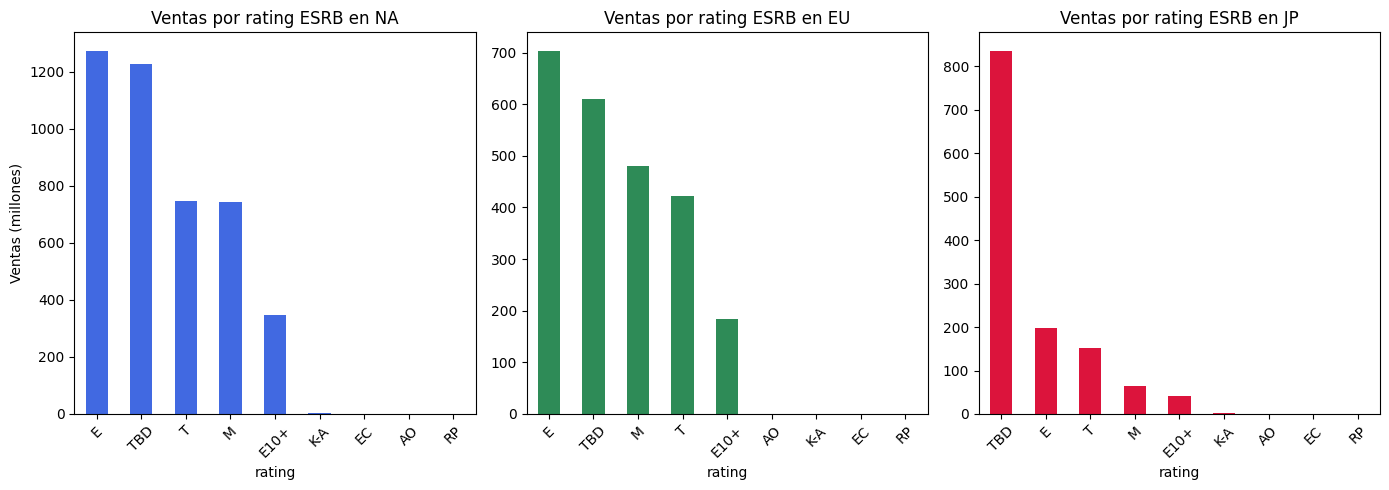

In [17]:
# Ventas por rating ESRB en cada región
na_rating = df.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
eu_rating = df.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
jp_rating = df.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)

# Gráfico comparativo
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
na_rating.plot(kind='bar', title='Ventas por rating ESRB en NA', ylabel='Ventas (millones)', color='royalblue')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
eu_rating.plot(kind='bar', title='Ventas por rating ESRB en EU', color='seagreen')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
jp_rating.plot(kind='bar', title='Ventas por rating ESRB en JP', color='crimson')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Conclusiones**

lataformas: En NA y EU dominan consolas como PS2, X360 y PS3. En Japón, la Nintendo DS y otras de Nintendo suelen tener mayores ventas.

Géneros: Los géneros de Acción y Shooter son populares en NA y EU. En Japón, Role-Playing (RPG) lidera claramente.

Rating ESRB: En NA y EU los juegos clasificados como "M" (Mature) y "E" (Everyone) dominan. En Japón, el impacto del rating ESRB es menor, ya que parte del mercado no lo usa de forma consistente.

**Paso 5. Prueba las siguientes hipótesis**

In [20]:
# Umbral de significancia
alpha = 0.05

# Limpiamos la columna de puntuación
df_clean = df[df['user_score'].notna() & (df['user_score'] != 'tbd')].copy()
df_clean['user_score'] = df_clean['user_score'].astype(float)

# --- Hipótesis 1: Xbox One vs PC ---
xone_scores = df_clean[df_clean['platform'] == 'XOne']['user_score']
pc_scores = df_clean[df_clean['platform'] == 'PC']['user_score']

t_stat1, p_val1 = st.ttest_ind(xone_scores, pc_scores, equal_var=False)

print("Hipótesis 1: Xbox One vs PC")
print(f"Estadístico t: {t_stat1:.3f}, valor p: {p_val1:.4f}")
if p_val1 < alpha:
    print("Rechazamos: hay diferencia significativa en las medias.")
else:
    print("No se rechaza: no hay evidencia suficiente de diferencia.")

# --- Hipótesis 2: Acción vs Deportes ---
action_scores = df_clean[df_clean['genre'] == 'Action']['user_score']
sports_scores = df_clean[df_clean['genre'] == 'Sports']['user_score']

t_stat2, p_val2 = st.ttest_ind(action_scores, sports_scores, equal_var=False)

print("\nHipótesis 2: Acción vs Deportes")
print(f"Estadístico t: {t_stat2:.3f}, valor p: {p_val2:.4f}")
if p_val2 < alpha:
    print("Rechazamos: hay diferencia significativa en las medias.")
else:
    print("No se rechaza: no hay evidencia suficiente de diferencia.")

Hipótesis 1: Xbox One vs PC
Estadístico t: -4.671, valor p: 0.0000
Rechazamos: hay diferencia significativa en las medias.

Hipótesis 2: Acción vs Deportes
Estadístico t: 1.789, valor p: 0.0737
No se rechaza: no hay evidencia suficiente de diferencia.


Explica:

— Cómo formulaste las hipótesis nula y alternativa.
    
    1. Hipótesis: Xbox One vs PC (calificaciones de usuarios)
        Esta es una prueba bilateral porque queremos ver si hay alguna diferencia, no una dirección específica (mayor o menor).
    2. Hipótesis: Acción vs Deportes (calificaciones de usuarios)
        También es una prueba bilateral, con la misma lógica.

— Qué criterio utilizaste para probar las hipótesis y por qué.
    
    - Las muestras provienen de grupos independientes (distintas plataformas o géneros).

    - Las varianzas pueden ser distintas, así que usamos la versión de Welch de la prueba t.

    - El número de observaciones puede variar bastante entre grupos.

    - Las calificaciones son numéricas 
    
 Criterio de decisión:
Se establece un nivel de significancia (α) típico: 0.05

Si el valor-p (p-value) es menor que 0.05, rechazamos la hipótesis nula.

Si el valor-p es mayor o igual a 0.05, no hay evidencia suficiente para rechazar.
    

**Paso 6. Escribe una conclusión general**

El análisis del mercado de videojuegos, basado en datos hasta 2016, ha permitido identificar tendencias importantes que pueden utilizarse para generar predicciones sobre el comportamiento del sector en 2017. 

La industria de los videojuegos mostró un crecimiento notable desde mediados de los años 90, con un pico de lanzamientos en 2008. A partir de ese año, el número de lanzamientos comenzó a disminuir, posiblemente debido a cambios en el modelo de distribución (como el auge de los juegos digitales y móviles).

Wii, PS2 y X360 dominaron las ventas globales históricas. Sin embargo, entre 2012 y 2016, el liderazgo pasó a plataformas como PS4, XOne y 3DS. Esto sugiere una transición generacional que ocurre aproximadamente cada 10 años.

El análisis anual mostró que las plataformas siguen un patrón claro de ascenso, madurez y declive, con una vida útil activa de entre 6 a 10 años. Esto es crucial para decisiones de inversión en desarrollo y publicación de videojuegos.

La puntuación de los críticos presenta una correlación moderada con las ventas (≈0.41), mientras que las puntuaciones de usuarios tienen una correlación muy baja. Esto sugiere que las reseñas profesionales podrían tener un mayor impacto en las decisiones de compra iniciales que las opiniones de los usuarios.

Aunque algunos juegos aparecen en múltiples plataformas, sus ventas pueden variar considerablemente. Esto puede deberse a la base de usuarios de cada consola, exclusividades o diferencias técnicas.

La mayoría de los juegos venden cantidades modestas, mientras que unos pocos títulos exitosos concentran grandes volúmenes de ventas, lo cual genera una distribución sesgada con muchos valores bajos y pocos outliers muy altos.

El análisis de plataformas activas entre 2012 y 2016 sirve como base para crear un modelo de predicción para el año 2017, identificando patrones recientes de éxito por plataforma.